In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)

Loading required package: limma


# Running on XX cell types

In [3]:
adata_pb = sc.read('./pb_adata_Cupr_Mg.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 44 × 16393
    obs: 'publication', 'label', 'cell_type', 'replicate_cat', 'sample', 'sample_rep', 'batch', 'lib_size', 'log_lib_size', 'replicate'
    uns: 'cell_type_colors', 'label_colors', 'log1p', 'pca', 'publication_colors', 'replicate_cat_colors', 'sample_colors', 'sample_rep_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [4]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'label']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'label']).size().unstack(fill_value=0)
summary_table

label,ctrl,stim
cell_type,,
BAMs,1,4
Mg_A,3,8
Mg_B,4,9
Mg_trt,2,9
cycl,0,4


In [5]:
adata_sub= adata_pb[np.in1d(adata_pb.obs['cell_type'], 
                           ['Mg_A', 'Mg_trt'])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (22, 16393)


In [6]:
pub_map = {
    '(this study)': 'Adams',
    'Shen et al. 2021': 'Shen'
}

# Update the 'treatment_meta' column based on the mapping
adata_sub.obs['batch'] = adata_sub.obs['publication'].map(pub_map)

In [7]:
# Concatenate 'individual_lesion_condition' and 'replicate' to create 'sample'
adata_sub.obs['cell_type_sample'] = adata_sub.obs['cell_type'].astype(str) + '_' + adata_sub.obs['sample_rep'].astype(str)

In [8]:
adata_sub.obs[:5]

,publication,label,cell_type,replicate_cat,sample,sample_rep,batch,lib_size,log_lib_size,replicate,cell_type_sample
donor_ctrl_3_0-0-0-0-0,Shen et al. 2021,ctrl,Mg_A,3,ctrl_3,Cupr_ctrl_Shen_2,Shen,240640,12.391057,3,Mg_A_Cupr_ctrl_Shen_2
donor_ctrl_4_0-0-0-0-0,Shen et al. 2021,ctrl,Mg_A,4,ctrl_4,Cupr_ctrl_Shen_1,Shen,3305175,15.011000,4,Mg_A_Cupr_ctrl_Shen_1
donor_ctrl_5_0-0-0-0-0,Shen et al. 2021,ctrl,Mg_A,5,ctrl_5,Cupr_ctrl_Shen_3,Shen,2702141,14.809555,5,Mg_A_Cupr_ctrl_Shen_3
donor_stim_2_0-0-0-0-0,(this study),stim,Mg_A,2,stim_2,Cupr_5w_2,Adams,33969,10.433204,2,Mg_A_Cupr_5w_2
donor_stim_3_0-0-0-0-0,Shen et al. 2021,stim,Mg_A,3,stim_3,Cupr_4+3w_1,Shen,125431,11.739511,3,Mg_A_Cupr_4+3w_1


# Subset for demyelination and remyelination MOL2 data

In [9]:
# Unique values in the 'condition' column
unique_conditions = adata_sub.obs['cell_type_sample'].unique()
for condition in unique_conditions:
    print(condition)

Mg_A_Cupr_ctrl_Shen_2
Mg_A_Cupr_ctrl_Shen_1
Mg_A_Cupr_ctrl_Shen_3
Mg_A_Cupr_5w_2
Mg_A_Cupr_4+3w_1
Mg_A_Cupr_4w_3
Mg_A_Cupr_4w_2
Mg_A_Cupr_4+3w_3
Mg_A_Cupr_4w_4
Mg_A_Cupr_4+3w_2
Mg_A_Cupr_4w_1
Mg_trt_Cupr_ctrl_Shen_1
Mg_trt_Cupr_ctrl_Shen_3
Mg_trt_Cupr_5w_1
Mg_trt_Cupr_5w_2
Mg_trt_Cupr_4+3w_1
Mg_trt_Cupr_4w_3
Mg_trt_Cupr_4w_2
Mg_trt_Cupr_4+3w_3
Mg_trt_Cupr_4w_4
Mg_trt_Cupr_4+3w_2
Mg_trt_Cupr_4w_1


In [10]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['cell_type_sample'], 
                           [
                            'Mg_A_Cupr_ctrl_Shen_2',
                            'Mg_A_Cupr_ctrl_Shen_1',
                            'Mg_A_Cupr_ctrl_Shen_3',
                            'Mg_trt_Cupr_4+3w_1',
                            'Mg_trt_Cupr_4+3w_2',
                            'Mg_trt_Cupr_4+3w_3',
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (6, 16393)


In [11]:
# Check if the 'sample_rep' column exists
if 'sample_rep' in adata_sub.obs.columns:
    # Set the 'sample_rep' column as the index
    adata_sub.obs.set_index('sample_rep', inplace=True)
else:
    print("The column 'sample_rep' does not exist in adata_sub.obs.")

adata_sub.obs.index.name = None

In [12]:
adata_sub.obs

,publication,label,cell_type,replicate_cat,sample,batch,lib_size,log_lib_size,replicate,cell_type_sample
Cupr_ctrl_Shen_2,Shen et al. 2021,ctrl,Mg_A,3,ctrl_3,Shen,240640,12.391057,3,Mg_A_Cupr_ctrl_Shen_2
Cupr_ctrl_Shen_1,Shen et al. 2021,ctrl,Mg_A,4,ctrl_4,Shen,3305175,15.011000,4,Mg_A_Cupr_ctrl_Shen_1
Cupr_ctrl_Shen_3,Shen et al. 2021,ctrl,Mg_A,5,ctrl_5,Shen,2702141,14.809555,5,Mg_A_Cupr_ctrl_Shen_3
Cupr_4+3w_1,Shen et al. 2021,stim,Mg_trt,3,stim_3,Shen,1995176,14.506243,3,Mg_trt_Cupr_4+3w_1
Cupr_4+3w_3,Shen et al. 2021,stim,Mg_trt,6,stim_6,Shen,556954,13.230238,6,Mg_trt_Cupr_4+3w_3
Cupr_4+3w_2,Shen et al. 2021,stim,Mg_trt,8,stim_8,Shen,33389606,17.323755,8,Mg_trt_Cupr_4+3w_2


# Rename the MOL clusters for NEW letter based nomenclature

In [13]:
#Check the counts data
print(adata_sub.X[:5, :5])

[[  0   0   0   0   0]
 [  2 106   4  48  48]
 [  0  71   3  48  29]
 [  0   0   1   4   3]
 [  0   4   0  10   2]]


# Start R code: QC of log transformation

In [14]:
%%R -i adata_sub

# Concatenate label and cell type for group factor
group <- colData(adata_sub)$label #ctrl or stim
replicate <- colData(adata_sub)$replicate #replicate number
batch <- colData(adata_sub)$batch

treatments <- data.frame("Group"=group, "Reps"=replicate, "Batch"= batch)
print(treatments)

                 Group Reps Batch
Cupr_ctrl_Shen_2  ctrl    3  Shen
Cupr_ctrl_Shen_1  ctrl    4  Shen
Cupr_ctrl_Shen_3  ctrl    5  Shen
Cupr_4+3w_1       stim    3  Shen
Cupr_4+3w_3       stim    6  Shen
Cupr_4+3w_2       stim    8  Shen


In [15]:
%%R

#Create a DGElist object using the anndata counts in 'X'
x <- DGEList(assay(adata_sub, "X"), group=colData(adata_sub)$label)

samplenames <- colnames(x$counts)

print("Dimensions before subsetting:")
print(dim(x))

# Check counts per group before filtering
print(table(x$samples$group))

[1] "Dimensions before subsetting:"
[1] 16393     6

ctrl stim 
   3    3 


In [16]:
%%R

cd <- x$samples$group
print(cd)

# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
print(design)

[1] ctrl ctrl ctrl stim stim stim
Levels: ctrl stim
  cdctrl cdstim
1      1      0
2      1      0
3      1      0
4      0      1
5      0      1
6      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [17]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.expr <- filterByExpr(x, design)
x2 <- x[keep.expr,, keep.lib.sizes=FALSE]
dim(x2)

[1] 9300    6


In [18]:
%%R
batch

Cupr_ctrl_Shen_2 Cupr_ctrl_Shen_1 Cupr_ctrl_Shen_3      Cupr_4+3w_1 
            Shen             Shen             Shen             Shen 
     Cupr_4+3w_3      Cupr_4+3w_2 
            Shen             Shen 
Levels: Shen


In [19]:
%%R

## OLD DON"T USE THIS

keep.exprs <- filterByExpr(x, group=batch)
b <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(b)

[1] 4582    6


In [20]:
%%R
#X is before trimming, Y is after trimming
L <- mean(x2$samples$lib.size) * 1e-6
M <- median(x2$samples$lib.size) * 1e-6
c(L, M)

[1] 6.979996 2.327638


In [21]:
%%R
## Calc norm factors before to normalize library sizes, then cpm divides counts by lib sizes
#X is before trimming, Y is after trimming, X2 is also trimmed but differently
x2 <- calcNormFactors(x2, method = "TMM")
x2$samples$norm.factors

[1] 1.2791949 1.3620806 1.2347002 0.5591936 0.9658162 0.8606812


In [22]:
%%R
#X2 is the norm lib sizes and trimmed
cpm <- edgeR::cpm(x2, log=FALSE, prior.counts=3)
lcpm <- edgeR::cpm(x2, log=TRUE, prior.count=3)

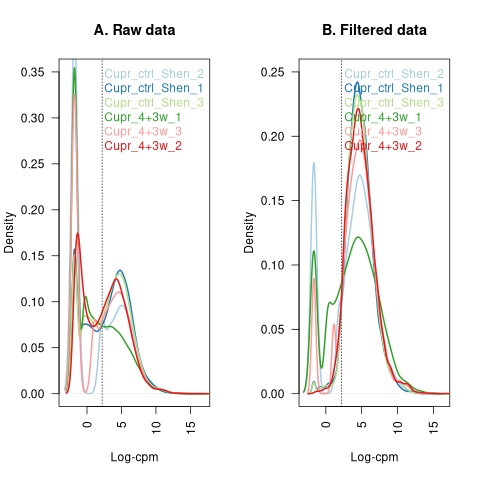

In [23]:
%%R
lcpm.cutoff <- log2(10/M + 2/L)
library(RColorBrewer)
nsamples <- ncol(x2)
col <- brewer.pal(nsamples, "Paired")

par(mfrow=c(1,2))

lcpm <- edgeR::cpm(x, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.35), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

lcpm <- edgeR::cpm(x2, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.25), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

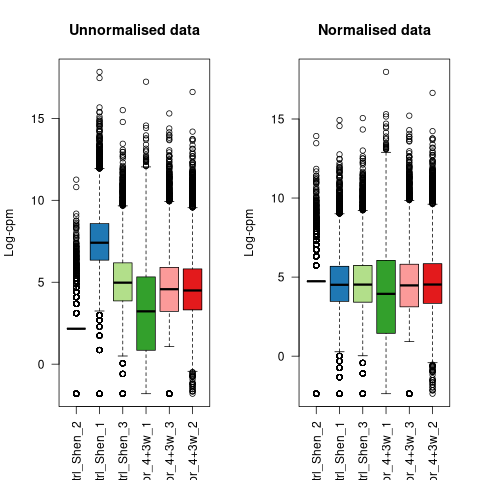

In [24]:
%%R
y2 <- x2
y2$samples$norm.factors <- 1
y2$counts[,1] <- ceiling(y2$counts[,1]*0.05)
y2$counts[,2] <- y2$counts[,2]*5

par(mfrow=c(1,2))
lcpm <- edgeR::cpm(y2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Unnormalised data", ylab="Log-cpm")

y3 <- calcNormFactors(y2)
y3$samples$norm.factors

lcpm <- edgeR::cpm(y3, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Normalised data", ylab="Log-cpm")

# Show how log transf + batch removal affects the separation of samples:

In [25]:
%%R
cd <- x2$samples$group
print(cd)

[1] ctrl ctrl ctrl stim stim stim
Levels: ctrl stim


In [26]:
%%R
#Make new count matrix with log counts and DGE data from X2 (trimmed, normfactors)
x3 <- x2
x3$counts <- lcpm

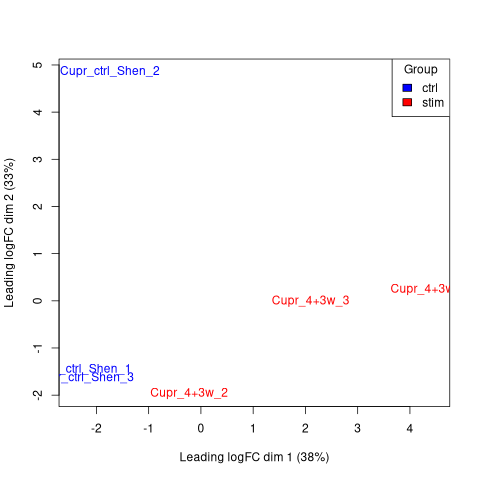

In [27]:
%%R
# Assuming 'group' is stored in y$samples dataframe
group <- x2$samples$group

# Generate a numeric vector from group factors (if not already factor, convert it)
group_factor <- as.factor(group)
group_colors <- as.numeric(group_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("blue", "red")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[group_colors])

# Adding a legend for clarity
legend("topright", legend=levels(group_factor), fill=colors, title="Group")

In [28]:
%%R
# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

  cdctrl cdstim
1      1      0
2      1      0
3      1      0
4      0      1
5      0      1
6      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [29]:
%%R
contr.matrix <- makeContrasts(cdstim - cdctrl, levels = colnames(design))
contr.matrix

        Contrasts
Levels   cdstim - cdctrl
  cdctrl              -1
  cdstim               1


In [30]:
%%R
# Convert to CPM and log2 transformation. 
logCPM <- edgeR::cpm(x2, log=TRUE, prior.count=3)

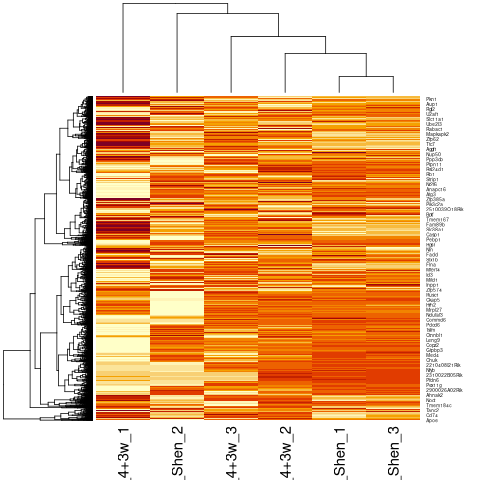

In [31]:
%%R
heatmap(logCPM)

# Lets try with voom:

In [32]:
%%R
# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

  cdctrl cdstim
1      1      0
2      1      0
3      1      0
4      0      1
5      0      1
6      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [33]:
%%R
contr.matrix <- makeContrasts(cdstim - cdctrl, levels = colnames(design))
contr.matrix

        Contrasts
Levels   cdstim - cdctrl
  cdctrl              -1
  cdstim               1


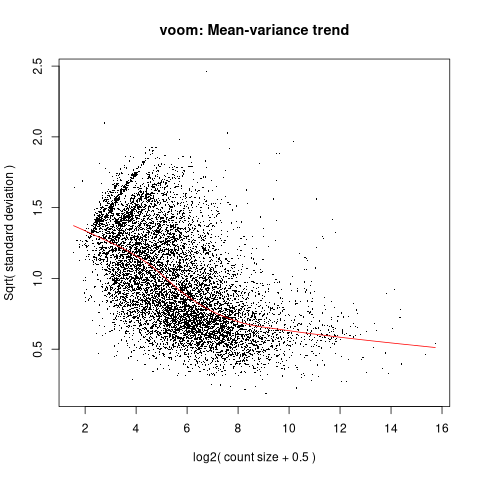

In [34]:
%%R
y <- voom(x2$counts, design, plot=TRUE)

In [35]:
%%R
fit <- lmFit(y, design)
head(coef(fit))

                cdctrl   cdstim
0610009B22Rik 4.429066 2.816962
0610009L18Rik 3.545329 3.072049
0610010F05Rik 3.222927 2.816134
0610010K14Rik 7.328325 5.312230
0610012G03Rik 5.630254 6.487719
0610030E20Rik 5.553830 5.137588


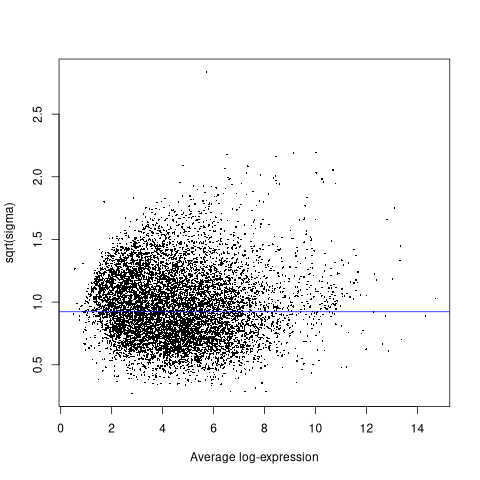

In [36]:
%%R
contr <- makeContrasts(cdstim - cdctrl, levels = colnames(coef(fit)))
tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [37]:
%%R
# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

            logFC   AveExpr         t      P.Value   adj.P.Val        B
Lyz2     5.104794 10.103155  14.77421 7.712228e-07 0.004300177 6.640674
Spp1    11.768442  5.822141  14.08596 1.092828e-06 0.004300177 3.582311
Cd63     3.023883  9.860817  12.80964 2.180168e-06 0.004300177 5.667068
Cd52     3.718690  8.885470  12.74431 2.262442e-06 0.004300177 5.611328
Bcl2a1d  4.618455  6.675289  12.49085 2.616475e-06 0.004300177 5.113131
Apoe     7.333739 12.793822  12.39004 2.774308e-06 0.004300177 5.424250
Capg     3.799097  6.966579  11.93598 3.631956e-06 0.004516648 5.011215
Bcl2a1a  3.846157  6.857658  11.75488 4.054460e-06 0.004516648 4.882157
Csmd3   -4.672335  7.632420 -11.63263 4.370950e-06 0.004516648 4.955352
Gpnmb   10.281300  3.792218  11.21473 5.682686e-06 0.005190884 2.879431


In [38]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 1004


In [39]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
significant_genes <- tt[tt$adj.P.Val < 0.05 & abs(tt$logFC) > 0.7, ]
num_significant_genes <- nrow(significant_genes)

# Print the number of significant genes
print(num_significant_genes)

[1] 1004


In [40]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
significant_genes <- tt[tt$adj.P.Val < 0.05 & abs(tt$logFC) > 1, ]
num_significant_genes <- nrow(significant_genes)

# Print the number of significant genes
print(num_significant_genes)

[1] 993


In [41]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 260
          logFC  AveExpr         t      P.Value   adj.P.Val           B
Spp1  11.768442 5.822141 14.085965 1.092828e-06 0.004300177  3.58231082
Gpnmb 10.281300 3.792218 11.214727 5.682686e-06 0.005190884  2.87943140
Apoc1  9.152331 4.460310  5.598744 6.293035e-04 0.019428058 -0.04860733
Igf1   9.050102 4.776384  7.387569 1.040814e-04 0.012769889  1.27874585
Apoc4  8.995926 3.162898  7.098018 1.360082e-04 0.013246696  1.05718838
Olr1   8.978068 3.204651  8.393430 4.364927e-05 0.011123314  1.78654508


In [42]:
%%R
if ('Gfap' %in% rownames(genes_up_sorted)) {
    print("Gene is in the index of genes_up_sorted")
} else {
    print("Gene is not in the index of genes_up_sorted")
}

[1] "Gene is not in the index of genes_up_sorted"


In [43]:
%%R
if ('Klk8' %in% rownames(genes_up_sorted)) {
    print("Gene is in the index of genes_up_sorted")
} else {
    print("Gene is not in the index of genes_up_sorted")
}

[1] "Gene is not in the index of genes_up_sorted"


In [44]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 733
              logFC   AveExpr         t      P.Value  adj.P.Val           B
Gm26802   -6.947601 1.0494472 -6.428406 2.610841e-04 0.01540621  0.54522260
Hist1h2ap -6.100327 2.3504104 -7.380486 1.047544e-04 0.01276989  1.44663951
Slc5a10   -6.086016 0.7397357 -5.751801 5.315936e-04 0.01892519 -0.02620475
Tmem44    -5.874069 1.8323108 -7.846948 6.921182e-05 0.01187099  1.59541305
Klrd1     -5.867522 0.6409199 -5.177712 1.017170e-03 0.02322140 -0.52415311
Khdrbs3   -5.854737 2.3357645 -6.256176 3.112604e-04 0.01599728  0.61482881


# If output --> change name!

In [ ]:
%%R
# Add row names as a new column
tt$gene <- rownames(tt)

# Optionally reorder or select columns
tt <- tt[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt, file = "./files/Cupr_remyel_Mg_ctrl_v_trt_voom_NEW.csv", 
            row.names = FALSE, sep = ",", quote = FALSE)

# Voom wqw

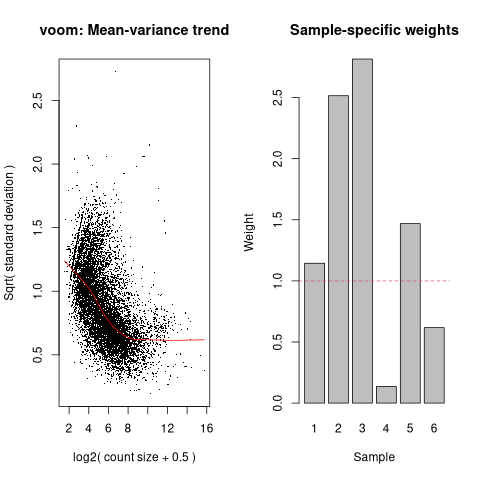

In [45]:
%%R

y_vqw_full <- voomWithQualityWeights(x2$counts, design, plot=TRUE)

In [52]:
%%R

fit <- lmFit(y_vqw_full, design)

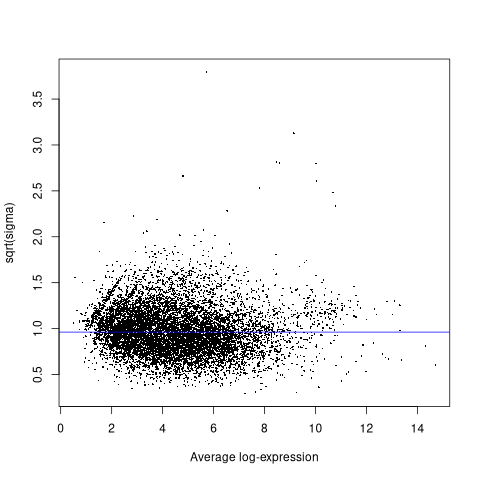

In [53]:
%%R

tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)
tt_full <- topTable(tmp2, sort.by = "P", n = Inf)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [54]:
%%R

# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

            logFC   AveExpr        t      P.Value    adj.P.Val         B
Spp1    11.853414  5.822141 22.18537 2.349556e-09 2.185087e-05  9.662733
Lgals3   8.535586  6.181333 19.85277 6.459612e-09 3.003719e-05  9.871127
Lpl      6.462351  6.565490 18.90984 1.004574e-08 3.114180e-05 10.177300
Apoe     6.775695 12.793822 17.34368 2.195917e-08 5.105507e-05  9.996144
Igf1     9.201708  4.776384 16.56238 3.327074e-08 5.392055e-05  8.263733
Bcl2a1d  4.606289  6.675289 16.09655 4.300290e-08 5.392055e-05  9.222453
Cst7     7.234787  5.313316 16.04893 4.416303e-08 5.392055e-05  8.499025
Gpnmb   10.812187  3.792218 15.96154 4.638327e-08 5.392055e-05  8.023306
Lyz2     4.715871 10.103155 15.02622 7.969424e-08 7.837768e-05  8.767956
Bcl2a1a  3.863947  6.857658 14.88355 8.679082e-08 7.837768e-05  8.629393


In [55]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 1515


In [56]:
%%R

# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 0.7, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 430
          logFC  AveExpr        t      P.Value    adj.P.Val        B
Spp1  11.853414 5.822141 22.18537 2.349556e-09 2.185087e-05 9.662733
Gpnmb 10.812187 3.792218 15.96154 4.638327e-08 5.392055e-05 8.023306
Olr1   9.644408 3.204651 13.28563 2.384505e-07 1.385994e-04 6.880984
Apoc4  9.301375 3.162898 12.69945 3.552944e-07 1.573447e-04 6.570543
Cybb   9.274054 4.346384 11.76617 6.946403e-07 2.227640e-04 6.117989
Igf1   9.201708 4.776384 16.56238 3.327074e-08 5.392055e-05 8.263733


In [57]:
%%R

# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -0.7, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 1085
              logFC   AveExpr         t      P.Value   adj.P.Val          B
Gm26802   -6.619430 1.0494472 -5.796269 2.319833e-04 0.006368942  0.9069900
Gm11523   -5.990735 0.5548992 -3.830537 3.803796e-03 0.032365330 -1.6171306
Hist1h2ap -5.820031 2.3504104 -8.087225 1.690476e-05 0.001391277  3.3957142
Slc5a10   -5.723653 0.7397357 -5.720277 2.558606e-04 0.006779212  0.8106238
Khdrbs3   -5.656683 2.3357645 -6.894133 6.126002e-05 0.002936692  2.2493104
Gm31243   -5.653803 2.2730434 -7.805975 2.259194e-05 0.001628721  3.1719124


## output

In [58]:
%%R
# Add row names as a new column
tt$gene <- rownames(tt)

# Optionally reorder or select columns
tt <- tt[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt, file = "./files/Cupr_remyel_MG_DAM_voom_wqw.csv", 
            row.names = FALSE, sep = ",", quote = FALSE)

# Check LR Pair Overlap

In [59]:
import liana as li
lr_pairs = li.resource.select_resource('mouseconsensus')
lr_pairs.head()

,ligand,receptor
31371,Dll1,Notch1
31372,Dll1,Notch2
31373,Dll1,Notch4
31374,Dll1,Notch3
31375,Nrg2,Erbb2_Erbb3


In [60]:
DEG_all = pd.read_csv('./files/Cupr_remyel_MG_DAM_voom_wqw.csv', index_col=None)
DEG_all.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
DEG_all.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
DEG_all.shape

(9300, 7)

In [61]:
sigs = DEG_all[(DEG_all.Padj < 0.05) & (abs(DEG_all.logFC) >= 1)]
sigs.shape

(1501, 7)

In [62]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 49


,ligand,receptor,logFC_ligand,logFC_receptor
16,Spp1,Ptger4,11.853414,4.979880
15,Spp1,Cd44,11.853414,6.243842
45,Lgals3,Eng,8.535586,-2.169218
32,Mmp12,Plaur,8.135874,2.569631
12,Cxcl14,Cxcr4,7.557942,6.910444
14,Apoe,Lrp5,6.775695,-2.068016
36,Apoe,Abca1,6.775695,1.905234
38,Lpl,Cd44,6.462351,6.243842
33,Ccl5,Sdc4,6.360841,3.407504
18,Ccl5,Ccrl2,6.360841,1.632204


In [63]:
sigs_up = DEG_all[(DEG_all.Padj < 0.05) & (DEG_all.logFC >= 1)]
sigs_up.shape

(425, 7)

In [64]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs_up['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 20


,ligand,receptor,logFC_ligand,logFC_receptor
6,Spp1,Ptger4,11.853414,4.979880
5,Spp1,Cd44,11.853414,6.243842
11,Mmp12,Plaur,8.135874,2.569631
4,Cxcl14,Cxcr4,7.557942,6.910444
14,Apoe,Abca1,6.775695,1.905234
16,Lpl,Cd44,6.462351,6.243842
7,Ccl5,Ccrl2,6.360841,1.632204
12,Ccl5,Sdc4,6.360841,3.407504
13,Vim,Cd44,5.892361,6.243842
0,Anxa2,Tlr2,5.754556,2.034209


In [ ]:
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']].to_csv('LR_Cupr_re_trt.tsv', sep='\t', index=False)